# Project Setup and Import Statements

This project leverages a variety of Python libraries to handle data manipulation, visualization, machine learning, preprocessing, model evaluation, and addressing class imbalance. Below are the consolidated import statements used in this project.

In [46]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, roc_curve)

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Load the Dataset

This section is responsible for loading the dataset into the environment and providing an initial glimpse of its structure. Proper error handling ensures that the process is robust and user-friendly.


In [47]:
# Load the dataset
try:
    data = pd.read_csv('./american_bankruptcy.csv')   
except FileNotFoundError:
    print("Dataset not found. Please check the file path.")

# Display the first few rows
data.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


# Explore the Dataset Structure

Understanding the structure of your dataset is crucial for effective data analysis and preprocessing. This section provides insights into the size and composition of the dataset, helping to identify potential issues and plan subsequent steps.

In [48]:
# Check the shape of the dataset
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

# Get basic info
data.info()

Dataset contains 78682 rows and 21 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  78682 non-null  object 
 1   status_label  78682 non-null  object 
 2   year          78682 non-null  int64  
 3   X1            78682 non-null  float64
 4   X2            78682 non-null  float64
 5   X3            78682 non-null  float64
 6   X4            78682 non-null  float64
 7   X5            78682 non-null  float64
 8   X6            78682 non-null  float64
 9   X7            78682 non-null  float64
 10  X8            78682 non-null  float64
 11  X9            78682 non-null  float64
 12  X10           78682 non-null  float64
 13  X11           78682 non-null  float64
 14  X12           78682 non-null  float64
 15  X13           78682 non-null  float64
 16  X14           78682 non-null  float64
 17  X15           78682 non-n

We generate descriptive statistics for the dataset, including count, mean, standard deviation, minimum, maximum, and quartile values for numerical columns, as well as counts and unique values for categorical columns.

In [49]:
# Summary statistics
data.describe(include='all')

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
count,78682,78682,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,...,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
unique,8971,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,C_4081,alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,73462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,...,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,NaN,NaN,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,...,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,NaN,NaN,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,...,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,NaN,NaN,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,...,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,NaN,NaN,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,...,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,NaN,NaN,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,...,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250


We check for missing values in each column and print out the columns that have missing values along with the count of missing entries.

In [50]:
# Check for missing values and duplicates
print("\nMissing values in each column:")
print(data.isnull().sum()[data.isnull().sum() > 0])


Missing values in each column:
Series([], dtype: int64)


We identify and count the number of duplicate rows in the dataset to assess data quality.

In [51]:
# Check for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


# Visualize the Target Variable

Understanding the distribution of the target variable is essential in any machine learning project. This section visualizes the distribution of the `status_label` to assess class balance and gain insights into the dataset's composition. Visualizing the target variable aids in identifying potential issues such as class imbalance, which can significantly impact model performance and evaluation.

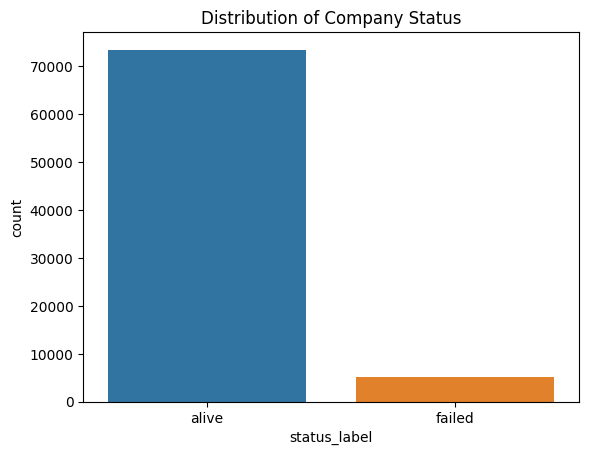


Class distribution:
alive     73462
failed     5220
Name: status_label, dtype: int64


In [52]:
# Visualize the target variable
sns.countplot(x='status_label', data=data)
plt.title('Distribution of Company Status')
plt.show()
print("\nClass distribution:")
print(data['status_label'].value_counts())

# Data Preprocessing

Preparing the dataset for machine learning involves several crucial preprocessing steps to ensure that the data is clean, consistent, and in a suitable format for modeling. This section outlines the steps taken to preprocess the dataset, including dropping unnecessary columns, handling data types, and encoding categorical variables.

In [53]:
# Drop unnecessary columns
data.drop(columns=['company_name'], inplace=True)

# Ensure 'year' is numeric
data['year'] = pd.to_numeric(data['year'], errors='coerce')

# Encode 'status_label' if necessary
if data['status_label'].dtype == 'object':
    label_encoder = LabelEncoder()
    data['status_label'] = label_encoder.fit_transform(data['status_label'])
    label_mapping = dict(
        zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("\nLabel Mapping:", label_mapping)


Label Mapping: {'alive': 0, 'failed': 1}


# Identify Columns with Negative Values

Ensuring data quality is a fundamental step in the data preprocessing pipeline. Negative values in certain columns may indicate data entry errors, invalid measurements, or specific characteristics of the data that need to be addressed. This section identifies which numerical columns contain negative values, allowing for informed decisions on how to handle them in subsequent analysis and modeling steps.


In [54]:
# Identify columns with negative values
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
negative_values = (data[numeric_cols] < 0).any()
print("Columns with negative values:")
print(negative_values[negative_values == True])

Columns with negative values:
X1     True
X2     True
X4     True
X6     True
X7     True
X9     True
X11    True
X12    True
X13    True
X15    True
X16    True
X18    True
dtype: bool


# Visualize Numerical Features with Boxplots

Boxplots are an effective way to visualize the distribution of numerical features in a dataset. They help in identifying the presence of outliers, understanding the spread of the data, and comparing distributions across different variables. This section generates boxplots for all numerical features (excluding the target variable) in the dataset, providing a comprehensive overview of their distributions.


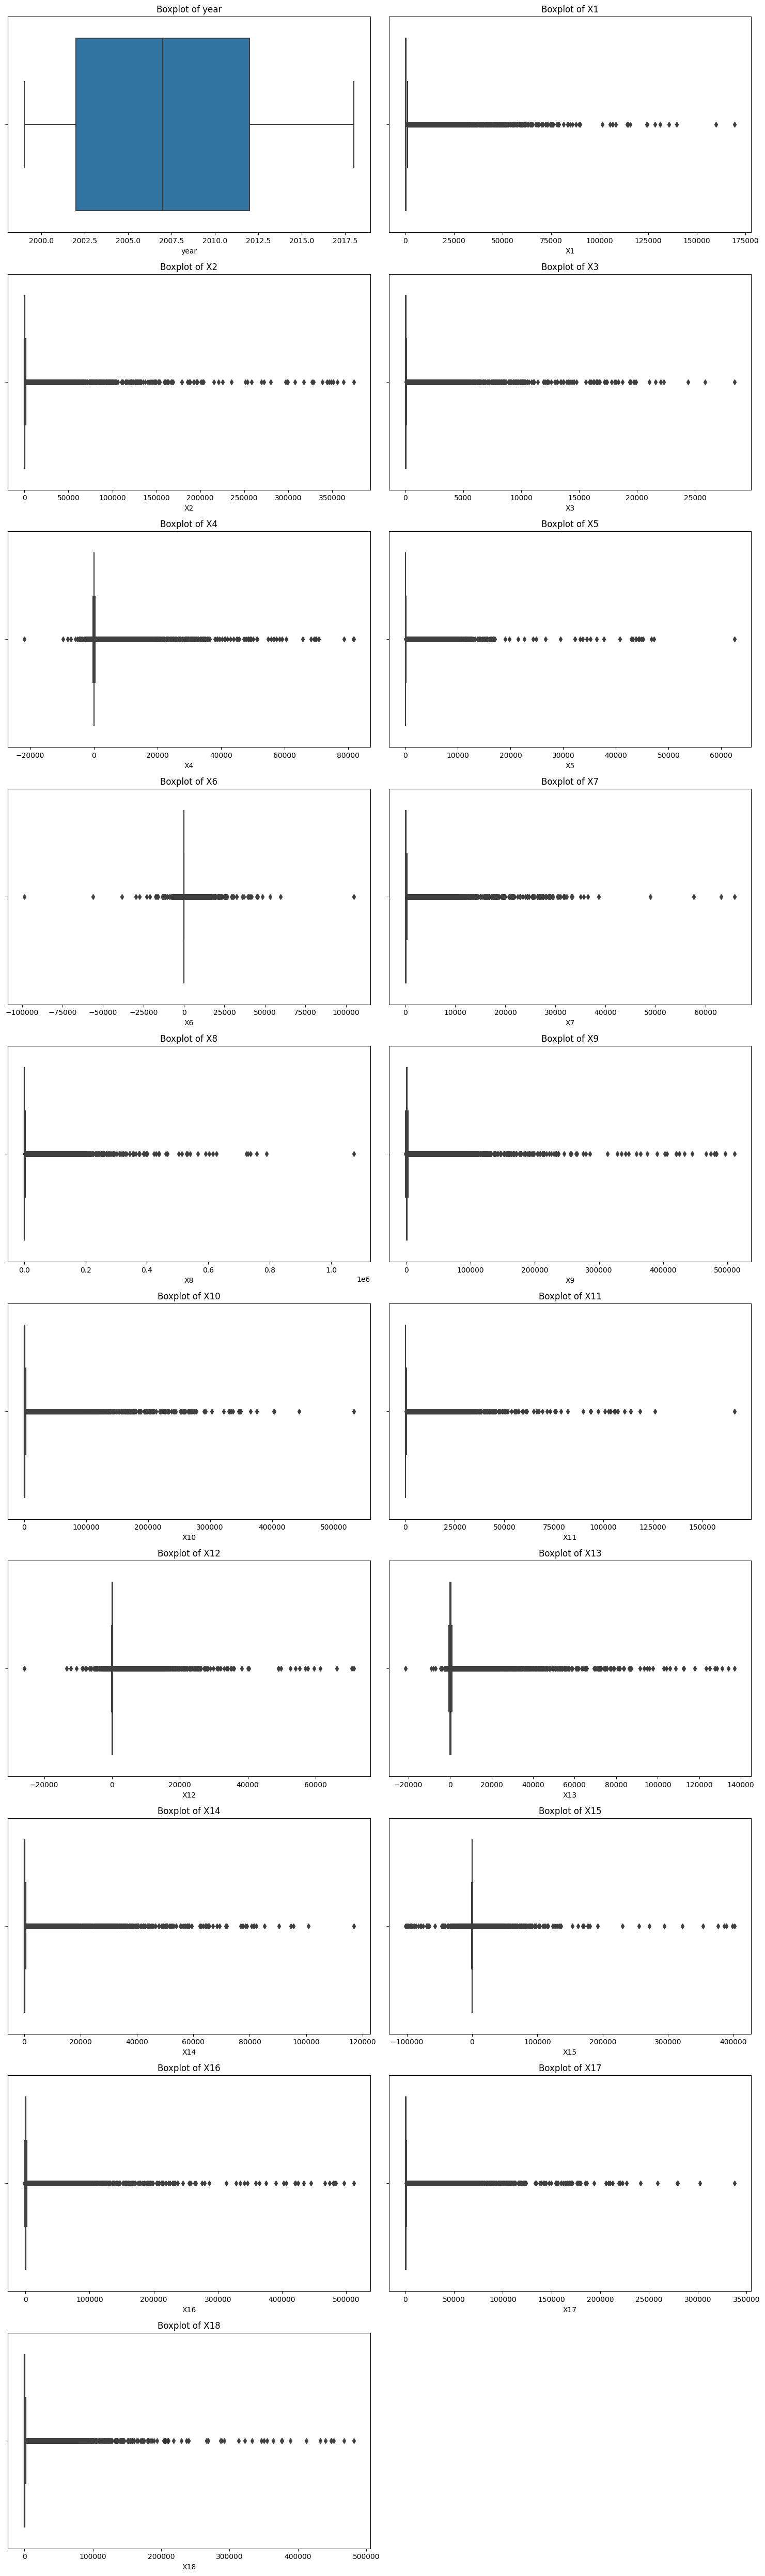

In [55]:
# Visualize numerical features with boxplots
numeric_cols.remove('status_label')
num_cols = len(numeric_cols)
num_cols_per_row = 2
num_rows = math.ceil(num_cols / num_cols_per_row)

fig, axes = plt.subplots(
    nrows=num_rows, ncols=num_cols_per_row, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Features to drop due to high correlation (> 0.8): ['X4', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X16', 'X17', 'X18']


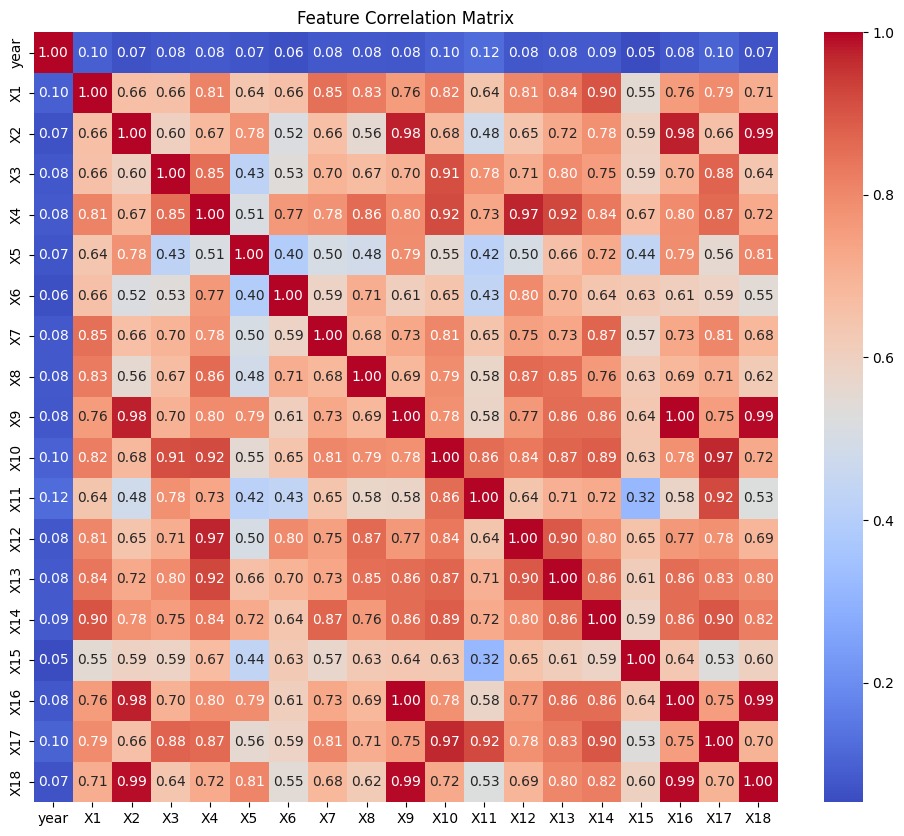

In [56]:
X = data.drop(columns='status_label')

# Compute the correlation matrix
corr_matrix = X.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than the threshold (e.g., 0.8)
threshold = 0.8
to_drop = [column for column in upper.columns if any(
    upper[column] > threshold)]

print(f"Features to drop due to high correlation (> {threshold}): {to_drop}")

# Drop the features from X
X_filtered = X.drop(columns=to_drop)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Outlier Detection and Removal in the Majority Class

Outliers can significantly skew the results of data analysis and machine learning models. This section focuses on identifying and removing outliers from the majority class in the dataset using the Interquartile Range (IQR) method. By targeting the majority class, we aim to refine the dataset without compromising the integrity of the minority class, which is crucial for maintaining class balance.


In [57]:
# Function to remove outliers based on IQR
def remove_outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Separate the data by class
data_majority = data[data['status_label'] == 0]
data_minority = data[data['status_label'] == 1]

print("Original majority class shape:", data_majority.shape)
print("Original minority class shape:", data_minority.shape)

# Apply the outlier removal to the majority class only
for col in numeric_cols:
    data_majority = remove_outliers_IQR(data_majority, col)

print("Majority class shape after outlier removal:", data_majority.shape)

# Recombine the data
data = pd.concat([data_majority, data_minority], axis=0).reset_index(drop=True)

# Verify class distribution after outlier removal
print("Class distribution after outlier removal:")
print(data['status_label'].value_counts())

Original majority class shape: (73462, 20)
Original minority class shape: (5220, 20)
Majority class shape after outlier removal: (27785, 20)
Class distribution after outlier removal:
0    27785
1     5220
Name: status_label, dtype: int64


# Split the Dataset into Training and Testing Sets

After preprocessing the data and ensuring its quality, the next crucial step is to prepare it for machine learning model training and evaluation. This involves separating the dataset into features and the target variable, followed by splitting the data into training and testing subsets. Proper splitting ensures that the model can generalize well to unseen data and provides an unbiased evaluation of its performance.

In [58]:
# Separate features and target variable
X = data.drop(columns=['status_label'])
y = data['status_label']

# Split the data into training and testing sets (before scaling and PCA)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution in y_train:")
print(y_train.value_counts())

Class distribution in y_train:
0    22228
1     4176
Name: status_label, dtype: int64


# Feature Scaling with StandardScaler

Scaling features is a critical preprocessing step in machine learning, especially for algorithms that are sensitive to the scale of input data (e.g., Support Vector Machines, Logistic Regression, and Neural Networks). This section applies feature scaling to the dataset using `StandardScaler` from Scikit-learn. The scaler is fitted on the training data to prevent data leakage and then applied to both the training and testing sets to ensure consistency.

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction with Principal Component Analysis (PCA)

Dimensionality reduction is a crucial step in the machine learning pipeline, especially when dealing with high-dimensional data. It helps in simplifying models, reducing computational costs, and mitigating the risk of overfitting. This section applies **Principal Component Analysis (PCA)** to the scaled features to reduce the number of dimensions while retaining 90% of the variance in the data.

In [60]:
# Apply PCA (fit PCA on training data only)
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 19
Reduced number of features after PCA: 6


PCA Components (Principal Components):
           PC1       PC2       PC3       PC4       PC5       PC6
year  0.000620  0.011938  0.074363 -0.992962  0.078319  0.037962
X1    0.278558  0.129911 -0.067034  0.010130  0.062754  0.140454
X2    0.267822  0.143050 -0.219143 -0.017948 -0.090477 -0.150521
X3    0.251264  0.031631  0.284347  0.019799  0.203380 -0.180467
X4    0.233846 -0.378535  0.098305 -0.002152 -0.039905  0.041047
X5    0.204214  0.206010 -0.416210 -0.045307 -0.054157  0.149663
X6   -0.040818 -0.524005 -0.336877 -0.039670 -0.180480  0.156793
X7    0.254429 -0.022228  0.162001  0.047888  0.292885  0.166914
X8    0.200577 -0.103159  0.067523  0.071655  0.590227  0.481025
X9    0.279949  0.107954 -0.207554 -0.018306 -0.090320 -0.056027
X10   0.273872 -0.126521  0.191749  0.006636  0.022273 -0.156881
X11   0.222518 -0.133658  0.325150 -0.010975 -0.319155 -0.198050
X12   0.139084 -0.538377 -0.069236 -0.017083 -0.199700  0.184884
X13   0.270103 -0.007274 -0.142596 -0.016441 -0.075

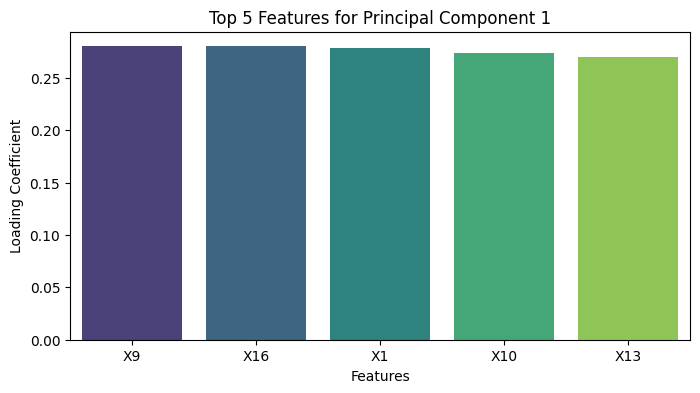

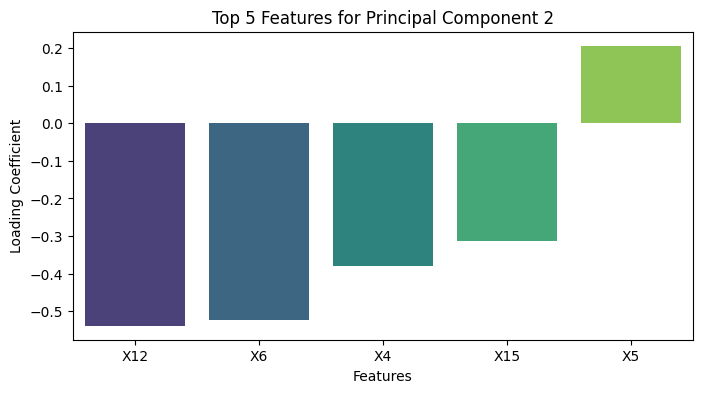

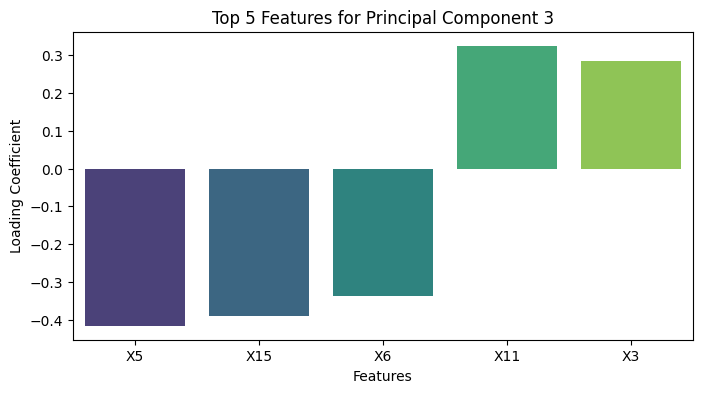

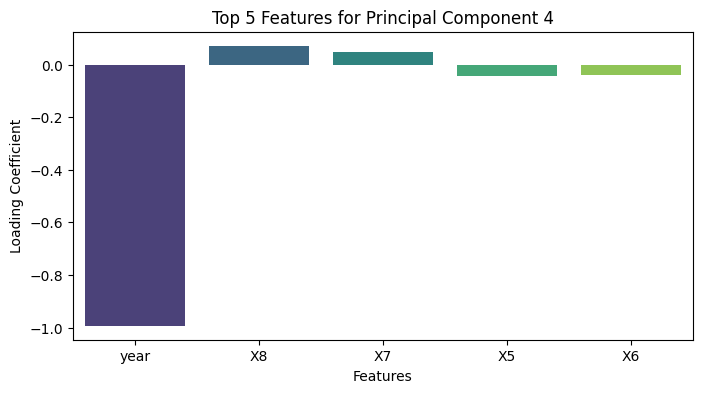

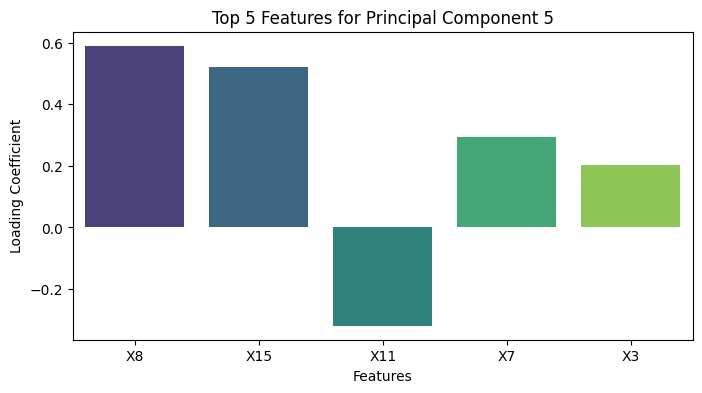

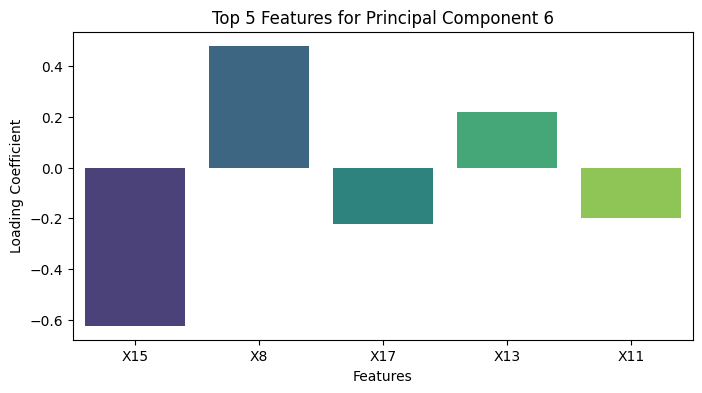

In [61]:
# Retrieve PCA components
pca_components = pca.components_

# Get the number of principal components
num_pcs = pca_components.shape[0]

# Create names for principal components
pc_names = [f'PC{i+1}' for i in range(num_pcs)]

# Retrieve original feature names
original_feature_names = X.columns.tolist()

# Create a DataFrame for PCA components with original feature names as columns
pca_df = pd.DataFrame(
    pca_components, columns=original_feature_names, index=pc_names)

# Transpose for better readability
pca_df = pca_df.transpose()

# Display the PCA components
print("PCA Components (Principal Components):")
print(pca_df)

# Function to plot top contributing features for each principal component

def plot_top_features(pca, feature_names, top_n=5):
    for i in range(pca.n_components_):
        component = pca.components_[i]
        abs_component = np.abs(component)
        top_indices = abs_component.argsort()[::-1][:top_n]
        top_features = [feature_names[j] for j in top_indices]
        top_values = component[top_indices]

        plt.figure(figsize=(8, 4))
        sns.barplot(x=top_features, y=top_values, palette='viridis')
        plt.title(f'Top {top_n} Features for Principal Component {i+1}')
        plt.xlabel('Features')
        plt.ylabel('Loading Coefficient')
        plt.show()


# Plot top 5 features for each principal component
plot_top_features(pca, original_feature_names, top_n=5)

# Handling Class Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)

Class imbalance is a common issue in machine learning, particularly in classification tasks where one class significantly outnumbers another. Imbalanced datasets can lead to biased models that favor the majority class, resulting in poor predictive performance for the minority class. To address this, **SMOTE (Synthetic Minority Over-sampling Technique)** is employed to create synthetic examples of the minority class, thereby balancing the class distribution and enhancing the model's ability to generalize effectively.

## Overview

This section demonstrates how to handle class imbalance in the training dataset using SMOTE. By resampling the training data, we aim to improve the classifier's performance on the minority class without altering the testing data, ensuring that the evaluation remains unbiased.

In [62]:
# Handling class imbalance with SMOTE
print("Class distribution in y_train before SMOTE:")
print(y_train.value_counts())

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_pca, y_train)

print("Class distribution in y_train after SMOTE:")
print(y_train_res.value_counts())

Class distribution in y_train before SMOTE:
0    22228
1     4176
Name: status_label, dtype: int64
Class distribution in y_train after SMOTE:
0    22228
1    22228
Name: status_label, dtype: int64


# Training a Logistic Regression Model

With the dataset now preprocessed, scaled, and balanced, the next step is to build and train a machine learning model. **Logistic Regression** is a fundamental classification algorithm that is widely used due to its simplicity, interpretability, and efficiency. This section demonstrates how to create, train, and make predictions using a Logistic Regression model on the prepared dataset.

In [63]:
# Create the model
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Train the model
log_reg.fit(X_train_res, y_train_res)

# Make predictions
y_pred_lr = log_reg.predict(X_test_pca)
y_prob_lr = log_reg.predict_proba(X_test_pca)[:, 1]

# Evaluating the Logistic Regression Model

After training the Logistic Regression model, it's essential to assess its performance to ensure that it generalizes well to unseen data. This section introduces an evaluation function that computes key performance metrics and visualizes the Receiver Operating Characteristic (ROC) curve. By systematically evaluating the model, we can gain insights into its strengths and areas for improvement.


Evaluation Metrics for Logistic Regression:
-------------------------------------
Accuracy: 0.8574
Precision: 0.5405
Recall: 0.6580
F1-Score: 0.5935
ROC-AUC Score: 0.8357

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      5557
           1       0.54      0.66      0.59      1044

    accuracy                           0.86      6601
   macro avg       0.74      0.78      0.75      6601
weighted avg       0.87      0.86      0.86      6601



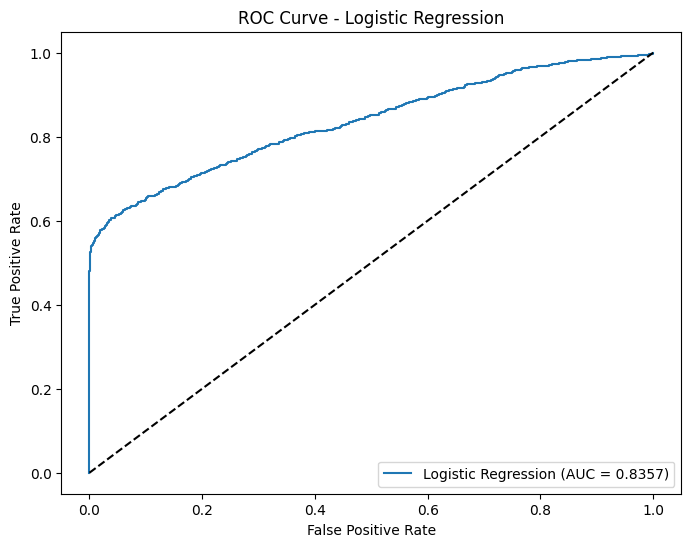

In [64]:

# Evaluate the model
def evaluate_model(y_test, y_pred, y_prob, model_name):
    print(f"\nEvaluation Metrics for {model_name}:")
    print("-------------------------------------")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression')


Evaluation Metrics for Support Vector Machine:
-------------------------------------
Accuracy: 0.9165
Precision: 0.8181
Recall: 0.6073
F1-Score: 0.6971
ROC-AUC Score: 0.8435

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5557
           1       0.82      0.61      0.70      1044

    accuracy                           0.92      6601
   macro avg       0.87      0.79      0.82      6601
weighted avg       0.91      0.92      0.91      6601



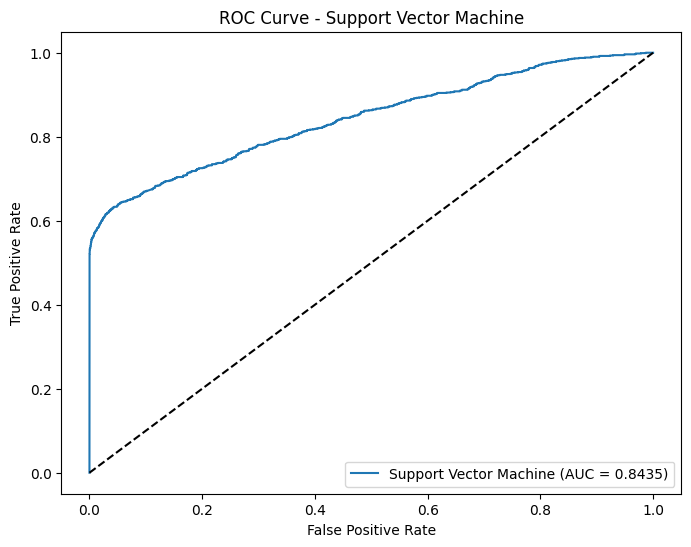

In [65]:
svc = SVC(probability=True, class_weight='balanced', random_state=42)
svc.fit(X_train_res, y_train_res)
y_pred_svc = svc.predict(X_test_pca)
y_prob_svc = svc.predict_proba(X_test_pca)[:, 1]

evaluate_model(y_test, y_pred_svc, y_prob_svc, 'Support Vector Machine')


Evaluation Metrics for Random Forest Classifier:
-------------------------------------
Accuracy: 0.9044
Precision: 0.7096
Recall: 0.6695
F1-Score: 0.6890
ROC-AUC Score: 0.8828

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5557
           1       0.71      0.67      0.69      1044

    accuracy                           0.90      6601
   macro avg       0.82      0.81      0.82      6601
weighted avg       0.90      0.90      0.90      6601



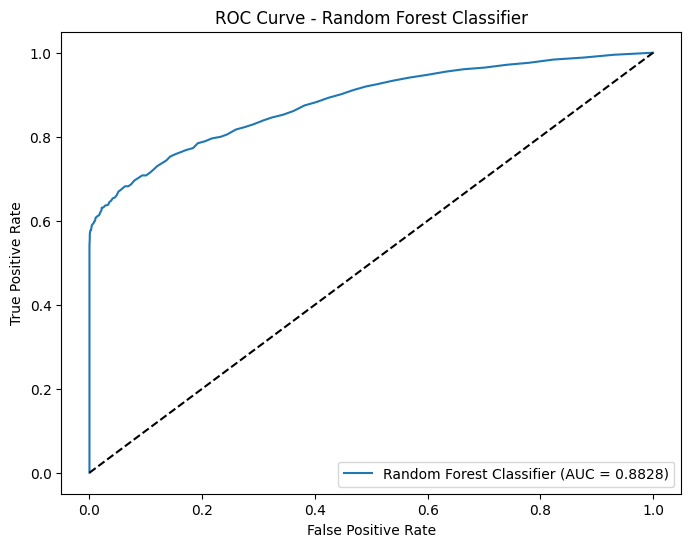

In [66]:
rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_pca)
y_prob_rf = rf.predict_proba(X_test_pca)[:, 1]

evaluate_model(y_test, y_pred_rf, y_prob_rf, 'Random Forest Classifier')